In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Standard MM1 Queue Simulator Class

In [4]:
class NonStationaryMM1:
    def __init__(self, arrival_rate_func, service_rate_func, T_end, 
                 initial_queue_length=0, max_queue_length=None, 
                 time_step=0.1, collect_waiting_times=True):
        """
         Non-stationary M/M/1 queue simulation
        
        Parameters:
        arrival_rate_func (callable): Function λ(t) returning arrival rate at time t
        service_rate_func (callable): Function μ(t) returning service rate at time t
        T_end (float): End time for simulation
        initial_queue_length (int): Starting number of vehicles in queue
        max_queue_length (int): Maximum allowed queue length (None for unlimited)
        time_step (float): Time resolution for statistics collection
        collect_waiting_times (bool): Whether to collect individual waiting times
        """
        self.lambda_t = arrival_rate_func
        self.mu_t = service_rate_func
        self.T_end = T_end
        self.max_queue_length = max_queue_length
        self.time_step = time_step
        
        # State variables
        self.current_time = 0.0
        self.queue_length = initial_queue_length
        self.next_arrival_time = self.generate_next_arrival_time(0)
        self.next_departure_time = float('inf')
        
        # Enhanced statistics
        self.queue_length_history = []
        self.time_history = []
        self.waiting_times = [] if collect_waiting_times else None
        self.arrival_times = {}  # Dictionary to track arrival times of each customer
        self.customer_id = 0     # Unique ID for each customer
        
        # Performance metrics
        self.total_arrivals = 0
        self.total_departures = 0
        self.total_waiting_time = 0
        self.rejected_arrivals = 0  # Count of arrivals rejected due to max queue length
    
    def generate_next_arrival_time(self, current_time):
        """
        Generate time until next arrival using non-homogeneous Poisson process
        """
        U = np.random.random()
        dt = -np.log(U) / self.lambda_t(current_time)
        return current_time + dt

    def generate_service_time(self, current_time):
        """
        Generate service time using current service rate
        """
        U = np.random.random()
        return -np.log(U) / self.mu_t(current_time)
        
    def step(self):
        """
        Enhanced step function with more statistics collection
        """
        # Record current state
        self.queue_length_history.append(self.queue_length)
        self.time_history.append(self.current_time)
        
        # Determine next event type
        if self.next_arrival_time <= self.next_departure_time:
            # Handle arrival
            self.current_time = self.next_arrival_time
            
            # Check max queue length
            if self.max_queue_length is None or self.queue_length < self.max_queue_length:
                self.queue_length += 1
                self.total_arrivals += 1
                
                # Track arrival time
                self.customer_id += 1
                self.arrival_times[self.customer_id] = self.current_time
                
                # If this is the only customer, schedule their departure
                if self.queue_length == 1:
                    service_time = self.generate_service_time(self.current_time)
                    self.next_departure_time = self.current_time + service_time
            else:
                self.rejected_arrivals += 1
                
            self.next_arrival_time = self.generate_next_arrival_time(self.current_time)
            
        else:
            # Handle departure
            self.current_time = self.next_departure_time
            self.queue_length -= 1
            self.total_departures += 1
            
            # Calculate waiting time for departing customer
            if self.waiting_times is not None:
                departed_customer = min(self.arrival_times.keys())
                waiting_time = self.current_time - self.arrival_times[departed_customer]
                self.waiting_times.append(waiting_time)
                self.total_waiting_time += waiting_time
                del self.arrival_times[departed_customer]
            
            # Schedule next departure if queue is not empty
            if self.queue_length > 0:
                service_time = self.generate_service_time(self.current_time)
                self.next_departure_time = self.current_time + service_time
            else:
                self.next_departure_time = float('inf')
    
    def run_simulation(self):
        """
        Run simulation until T_end
        """
        while self.current_time < self.T_end:
            self.step()
    
    def get_statistics(self):
        """
        Return summary statistics of the simulation
        """
        stats = {
            'average_queue_length': np.mean(self.queue_length_history),
            'max_queue_length': max(self.queue_length_history),
            'total_arrivals': self.total_arrivals,
            'total_departures': self.total_departures,
            'rejected_arrivals': self.rejected_arrivals
        }
        
        if self.waiting_times:
            stats.update({
                'average_waiting_time': np.mean(self.waiting_times),
                'max_waiting_time': max(self.waiting_times),
                'min_waiting_time': min(self.waiting_times)
            })
            
        return stats


### Traffic Queue Model Configuration and Run

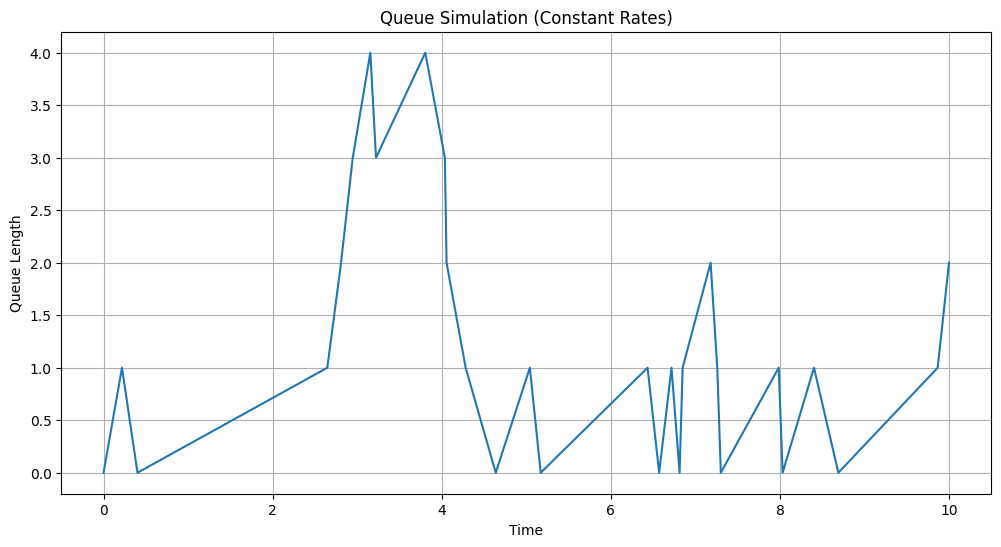


Simulation Statistics:
average_queue_length: 1.24
max_queue_length: 4.00
total_arrivals: 16.00
total_departures: 13.00
rejected_arrivals: 0.00
average_waiting_time: 0.48
max_waiting_time: 1.23
min_waiting_time: 0.05


In [20]:
def simple_arrival_rate(t):
    # constant arrival rate of 2 cars per unit time
    return 2

def simple_service_rate(t):
    # constant service rate of 3 cars per unit time
    return 3

if __name__ == "__main__":
    # create simulation
    sim = NonStationaryMM1(
        arrival_rate_func=simple_arrival_rate,
        service_rate_func=simple_service_rate,
        T_end=10,  # Run for 10 time units
        initial_queue_length=0,
        max_queue_length=10,  # Set a small maximum queue length
        time_step=0.1
    )

    # run simulation
    sim.run_simulation()

    # plotting
    plt.figure(figsize=(12, 6))
    plt.plot(sim.time_history, sim.queue_length_history)
    plt.xlabel('Time')
    plt.ylabel('Queue Length')
    plt.title('Queue Simulation (Constant Rates)')
    plt.grid(True)
    plt.show()

    # print stats
    stats = sim.get_statistics()
    print("\nSimulation Statistics:")
    for key, value in stats.items():
        print(f"{key}: {value:.2f}")